# Creating dataframe

In [1]:
import pandas as pd
import requests
import csv
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import time as ti
from bs4 import BeautifulSoup
import numpy as np
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors




# Extracting steam Ids

# players data from steam Community

# saving steam ids in csv 
 there was a problem in saving cause number were changing  ,what is below is another way to save extracted ids in txt file 

# Extracting users Games info

# Here another game info function but for release year 

# Below function another api called steam spy to get Is Multiplayer values , steam didn't have it  

In [2]:
#droping rows that is empty or wasn't be able to get info 
#anlaysing
#------------------------------
def fill_missing_scores(df):
    # Calculate the average score
    average_score = df['Score'].mean()

    # Calculate the median score
    median_score = df['Score'].median()

    # Fill missing scores with the average or median score
    df['Score'].fillna(average_score, inplace=True)  # Use average_score or median_score

    return df


#-----------------------------
def drop_duplicate():
    #loading csv file 
    df=pd.read_csv("PlayerGamesInfo.csv")
    le=len(df)
    num_cells = df.count().sum()
    print("Number of var:", num_cells)

    
    df.drop_duplicates(subset=['steam_id', 'appID'], keep='first', inplace=True)   
    #droping where name and same game exist more then one time 
    print('Rows dropped: ',le-len(df))#count how many rows dropped
    #le=len(df)
    df.dropna(subset=['Publisher', 'Developer'],inplace=True)
    # where games id didn't work no info was found about the game
    print('Rows dropped: ', le-len(df))
    column_names = df.columns.tolist()
    #print(column_names)
    print("Empty Row with Score 0 : ",len(df[df['Score'].isna()]))
    df=fill_missing_scores(df)
    print("Empty Row with Score 0 : ",len(df[df['Score'].isna()]))
    
    missing_release_year = df[df['Release Year'].isnull()]
    print("None Release :",len(missing_release_year))
    df = df.dropna(subset=['Release Year'])
    missing_release_year = df[df['Release Year'].isnull()]
    print("None Release :",len(missing_release_year))
    df.to_csv('PlayerGamesInfo1.csv', index=False)
    num_cells = df.count().sum()
    print("Number of var:", num_cells)
drop_duplicate()

Number of var: 443422
Rows dropped:  0
Rows dropped:  3643
Empty Row with Score 0 :  532
Empty Row with Score 0 :  0
None Release : 467
None Release : 0
Number of var: 410032


# Top 15 developers 

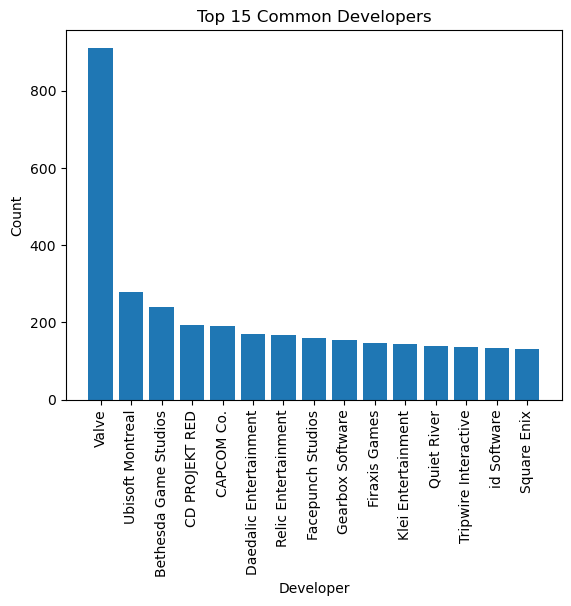

In [3]:
#show the top 15 developers.
#Here you can see the top developers among many games with many players 
def plot_top_developers(df):
    # Split the developer names in each cell
    all_developers = df['Developer'].str.split(',', expand=True).stack().str.strip().tolist()

    # Exclude specific strings
    excluded_strings = ['Ltd', 'Inc','LLC']
    all_developers = [developer for developer in all_developers if all(substring not in developer for substring in excluded_strings)]

    # counts of each developer
    developer_counts = pd.Series(all_developers).value_counts().head(15)

    #bar chart
    plt.bar(developer_counts.index, developer_counts.values)
    plt.xlabel('Developer')
    plt.ylabel('Count')
    plt.title('Top 15 Common Developers')

   
    plt.xticks(rotation=90)

    plt.show()



warnings.filterwarnings("ignore", category=UserWarning, module="IPython")
#loading the new anlayesd dataframe 
df=pd.read_csv("PlayerGamesInfo1.csv")
plot_top_developers(df)

# Top 10 Played Games 
Using amount of hours to find top 10 played games

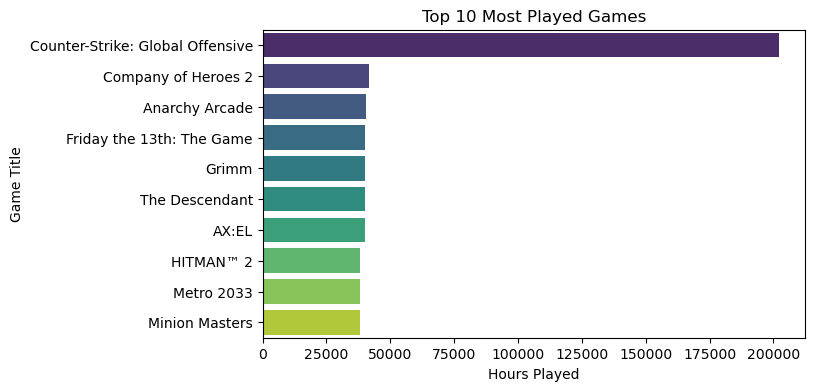

In [4]:
N = 10
top_played_games = df.groupby('Game Title')['Hours Played'].sum().nlargest(N)

# Bar plot of top played games
plt.figure(figsize=(7, 4))
sns.barplot(x=top_played_games.values, y=top_played_games.index, palette='viridis')
plt.xlabel('Hours Played')
plt.ylabel('Game Title')
plt.title(f'Top {N} Most Played Games')
plt.show()

# Visualizations for Games Scores

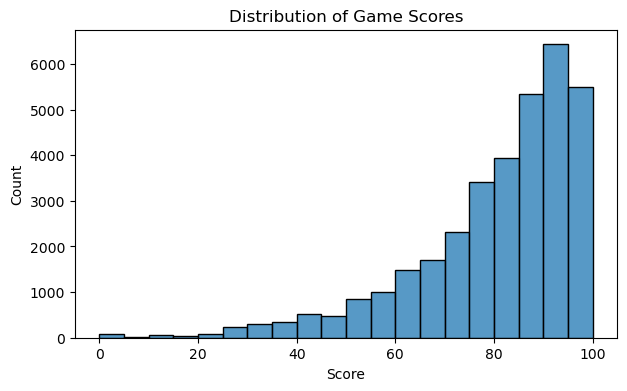

In [5]:
# Histogram of game score
plt.figure(figsize=(7, 4))
sns.histplot(data=df, x='Score', bins=20)
plt.title('Distribution of Game Scores')
plt.show()

# Score and Hours Outliers 
Here we can see diagram that show theres some outliers far from the average in     

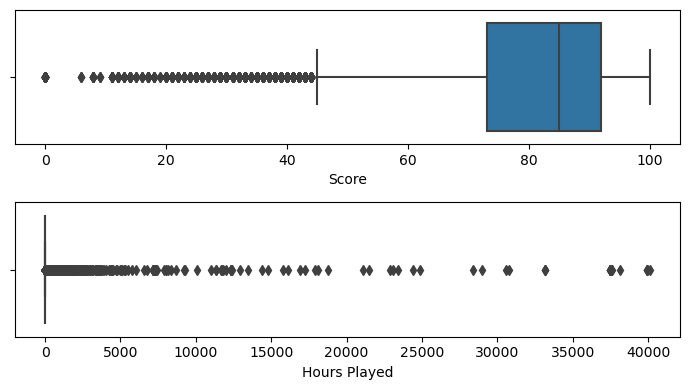

In [6]:
plt.figure(figsize=(7, 4))
plt.subplot(2, 1, 1)
sns.boxplot(data=df, x='Score')
plt.subplot(2, 1, 2)
sns.boxplot(data=df, x='Hours Played')
plt.tight_layout()
plt.show()

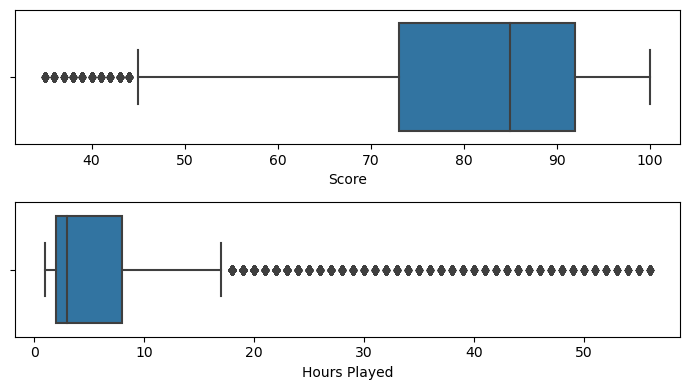

Number of cells with data: 367736


In [7]:
#bounds for outlier removal
score_lower_bound = df['Score'].quantile(0.25) - 2.0 * (df['Score'].quantile(0.75) - df['Score'].quantile(0.25))
score_upper_bound = df['Score'].quantile(0.75) + 2.0 * (df['Score'].quantile(0.75) - df['Score'].quantile(0.25))

hours_lower_bound = df['Hours Played'].quantile(0.25) - 5.0 * (df['Hours Played'].quantile(0.75) - df['Hours Played'].quantile(0.25))
hours_upper_bound = df['Hours Played'].quantile(0.75) + 5.0 * (df['Hours Played'].quantile(0.75) - df['Hours Played'].quantile(0.25))

#remove outliers
df = df[(df['Score'] >= score_lower_bound) & (df['Score'] <= score_upper_bound)]
df = df[(df['Hours Played'] >= hours_lower_bound) & (df['Hours Played'] <= hours_upper_bound)]

plt.figure(figsize=(7, 4))
plt.subplot(2, 1, 1)
sns.boxplot(data=df, x='Score')
plt.subplot(2, 1, 2)
sns.boxplot(data=df, x='Hours Played')
plt.tight_layout()
plt.show()
num_cells_with_data = df.count().sum()
print("Number of cells with data:", num_cells_with_data)

# Diagram for Score connection with amount of hours 
it's show there is a big deffrences and connections with the amount of hours , to many low score have but as we see as much more hours as much score get higher we see high score more in more hourse spended , there is also a little amount of outliers, as you see there is relation between as much hours played more games have positive score 

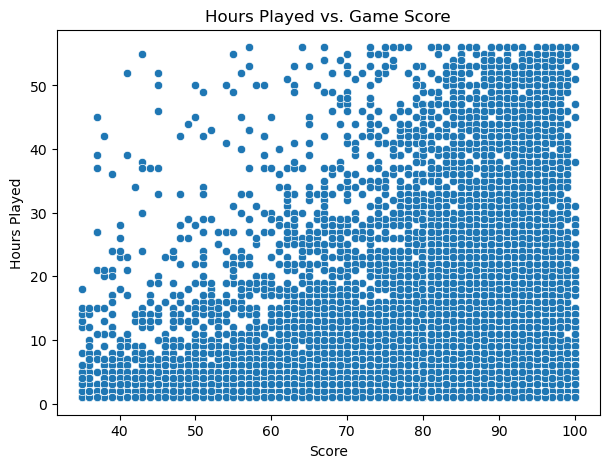

In [8]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df,x='Score', y='Hours Played')
plt.title('Hours Played vs. Game Score')
plt.show()



# Using machine Learning algorithems
Encoding Games titles to number value in new Columons to fit machine learning 

# KNeighbors Algorithms:

In [9]:
selected_columns = ['IsMultiplayer', 'Genre', 'Score','Game Title']
df_selected = df[selected_columns]

#cast features to numerical labels
label_encoder = LabelEncoder()
df_selected['IsMultiplayer'] = label_encoder.fit_transform(df_selected['IsMultiplayer'])
df_selected['Genre'] = label_encoder.fit_transform(df_selected['Genre'])

# Split into train and test sets
X = df_selected[['IsMultiplayer', 'Genre', 'Score']]
y = pd.cut(df_selected['Score'], bins=[0, 50, 100], labels=[0, 1])  #Score to categorical labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the KNN model
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
# remove warnings
warnings.filterwarnings("ignore")

#predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

#print accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_accuracy}")
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")


C:\Users\Fadi-\AppData\Local\Temp\ipykernel_16664\2794539259.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['IsMultiplayer'] = label_encoder.fit_transform(df_selected['IsMultiplayer'])
C:\Users\Fadi-\AppData\Local\Temp\ipykernel_16664\2794539259.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Genre'] = label_encoder.fit_transform(df_selected['Genre'])


Train Accuracy: 0.9991435562805873
Test Accuracy: 0.9982058391779481


# Solution:
Recommanded games depend on user name and his games data using KNN algorithem 

In [12]:
ls=set()
genre_values = df['Genre'].unique()
for i in genre_values[:10]:
    if isinstance(i, str) and ',' in i:
        newls=i.split(',')
        ls.update(newls)
k=0
print("List of Genre you can use:")
for gen in ls:
    if k == len(ls)-1:
        print(gen.strip(),end=" " )
    else:
         print(gen.strip(),end="," )
    k+=1
print('')

# inputs
user_genre = label_encoder.transform([input("Enter your preferred game genre: ")])
user_score = float(input("Enter your preferred game score (0-100): "))

user_input = [[0, user_genre, user_score]]

warnings.filterwarnings("ignore")

# nearest neighbors based on user input
distances, indices = model.kneighbors(user_input)

#recommended games 
recommended_games = df_selected.iloc[indices[0]]['Game Title']

# Print recom games
recommended_games=list(set(recommended_games))
print("----------------------------------\nRecommended Games:")
for game in recommended_games:
    print(game)


List of Genre you can use:
Adventure,Simulation,RPG,Casual,Indie,Strategy,Action,Free to Play 
Enter your preferred game genre: Adventure
Enter your preferred game score (0-100): 80
----------------------------------
Recommended Games:
Porcunipine
The Howler
Wargame: AirLand Battle
Assassin's Creed Syndicate
Machine Made: Rebirth
